### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import pylab

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
States_track = {}

# Initialise states to be tracked
def initialise_tracking_states():
    env = CabDriver()
    action_space, state_space, _ = env.reset()
    states_to_track = random.sample(state_space, k=5)
    for state in states_to_track: 
        States_track[state] = []


In [4]:
initialise_tracking_states()
States_track

{(2, 19, 6): [], (1, 12, 1): [], (1, 7, 4): [], (3, 10, 2): [], (2, 8, 0): []}

In [5]:
#Defining a function to save an object as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01      
        self.epsilon = 1    # Initialize epsilon at max value
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()


    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        return model

    def get_action(self, state, env):
        # Write your code here:
        possible_actions_index, actions = env.requests(state)
        # get action from model using epsilon-greedy policy
        if np.random.rand() <= self.epsilon:
            action = random.choice(actions) #explore
        else:
            q_value = -1000 #initialize to lowest int value
            action = None
            for a in actions: 
                encoded_state = env.state_encod_arch2(state, a)
                q_value_from_model = self.model.predict(encoded_state.T)
                if (q_value_from_model > q_value):
                    q_value = q_value_from_model
                    action = a
        
        return action
        
        
    def append_sample(self, state, action, reward, next_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))           
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self, env):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)

            update_output = np.zeros((self.batch_size, self.action_size))# write here
            update_input = np.zeros((self.batch_size, self.state_size))# write here
            
            actions, rewards = [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]                
                action_index = env.action_space.index(action)
                                          
                # Write your code from here
                # 1. Predict the target from earlier model
                target = self.model.predict(env.state_encod_arch2(state, action).T)
                # 2. Get the target for the Q-network
                future_q_values = []
                for a in env.action_space:
                    future_q_values.append( self.model.predict(env.state_encod_arch2(next_state, a).T) )
                
                #3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair
                update_input[i] = env.state_encod_arch2(state, action).flatten()
                rewards.append(reward)
                actions.append(action)
                
                # Update the target value according to the update policy of Q-learning
                # R_t + γ ∗ max Q_t(S_{t+1},a)−Q_t(S_t,a_t)
                # Q Learning: get maximum Q value at s' from target model
                update_output[i] = reward + self.discount_factor * (max(future_q_values))
                
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, update_output, batch_size=self.batch_size, epochs=1, verbose=0)


    def save(self, name):
        self.model.save_weights(name)

In [7]:
# test code 
env = CabDriver()
_,_,state = env.reset()
print(len(env.state_encod_arch1(state)))
agent = DQNAgent(len(env.state_encod_arch2(state, tuple((0,0)))), 1)
agent.epsilon = 0

action = agent.get_action(env.state_init, env)
print(action)
print(env.action_space.index(action))
env.next_state_func(state, action, Time_matrix)

36
(4, 0)
16


((0, 13, 2), 6.0)

In [8]:
Episodes = 1000

### DQN block

episode 0, reward -412.0, memory_length 155, epsilon 0.995
episode 25, reward 135.0, memory_length 2000, epsilon 0.8778091417340573
episode 50, reward 225.0, memory_length 2000, epsilon 0.7744209942832988
episode 75, reward 364.0, memory_length 2000, epsilon 0.6832098777212641
episode 100, reward 414.0, memory_length 2000, epsilon 0.6027415843082742
episode 125, reward 909.0, memory_length 2000, epsilon 0.531750826943791
episode 150, reward 981.0, memory_length 2000, epsilon 0.46912134373457726
episode 175, reward 835.0, memory_length 2000, epsilon 0.41386834584198684
episode 200, reward 1195.0, memory_length 2000, epsilon 0.36512303261753626
episode 225, reward 1364.0, memory_length 2000, epsilon 0.322118930542046
episode 250, reward 1065.0, memory_length 2000, epsilon 0.28417984116121187
episode 275, reward 1353.0, memory_length 2000, epsilon 0.2507092085103961
episode 300, reward 1152.0, memory_length 2000, epsilon 0.2211807388415433
episode 325, reward 1399.0, memory_length 2000, e

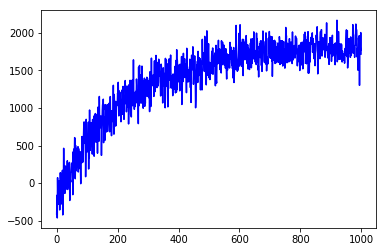

In [9]:
env = CabDriver()
action_space, state_space, state = env.reset()
state_size = len(env.state_encod_arch2(state, tuple((0,0))))
agent = DQNAgent(state_size, 1)
scores, episodes = [], []


for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    _, _, state = env.reset()
    # Call all the initialised variables of the environment
    terminal_state = False
    hours_run = 0
    total_reward = 0

    # Call the DQN agent
    # Every episode lasts 30 days
    while not terminal_state:        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(state, env)
        # 2. Evaluate your reward and next state
        reward = env.reward_func(state, action, Time_matrix)
        next_state, trip_hours = env.next_state_func(state, action, Time_matrix)
        # 3. Append the experience to the memory
        agent.append_sample(state, action, reward, next_state)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        # 5. Keep a track of rewards, Q-values, loss
        total_reward = total_reward + reward
        if state in States_track.keys():
            States_track[state].append(agent.model.predict(env.state_encod_arch2(state, action).T))

        state = next_state
        hours_run = hours_run + trip_hours
        terminal_state = (hours_run >= 24*30)
        
    scores.append(total_reward)
    episodes.append(episode)

    # Decay in ε after each episode       
    agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)

    #save the model 
    if episode % 25 == 0:
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,
                                                                         total_reward,
                                                                         len(agent.memory),
                                                                         agent.epsilon))
        agent.model.save_weights("./dqn_arch2.h5")

        
pylab.plot(episodes, scores, 'b')


### Tracking Convergence

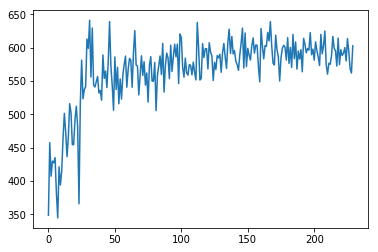

In [20]:
aKey = list(States_track.keys())[0]
qvals = States_track[aKey]
q = [j[0][0] for j in qvals for i in j]
time = range(0, len(q))
plt.plot(time, q)
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [22]:
time = np.arange(0,2000)
epsilon = [1.0]
for i in range(1,2000):
    epsilon.append(epsilon[i-1]*0.995)

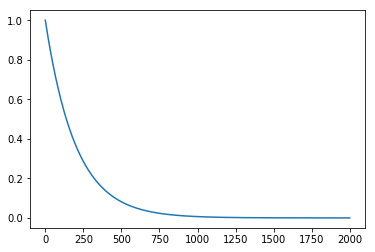

In [23]:
plt.plot(time, epsilon)
plt.show()